In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time

## Feature pre-processing

In [2]:
# Load the cleaned dataset
df = pd.read_csv('cleaned_df.csv', index_col=0)
df.head()

,age,workclass,education_num,marital_status,occupation,race,sex,hours_per_week,native_country,target
0,39,State-gov,13,Never-married,Adm-clerical,White,Male,40,US,<=50K
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,White,Male,13,US,<=50K
2,38,Private,9,Divorced,Handlers-cleaners,White,Male,40,US,<=50K
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Black,Male,40,US,<=50K
4,28,Private,13,Married-civ-spouse,Prof-specialty,Black,Female,40,Other_Americans,<=50K


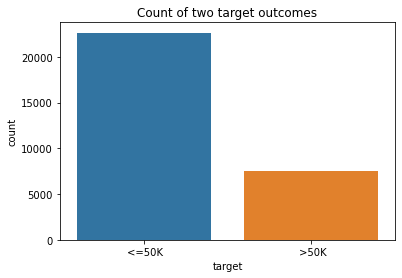

In [3]:
sns.countplot(x=df['target'])
plt.title('Count of two target outcomes')
plt.show()

In [4]:
# One-hot encoding
df['sex'] = df['sex'].map({' Male':0, ' Female':1})
df['target'] = df['target'].map({' <=50K':0, ' >50K':1})
df = pd.get_dummies(df, drop_first=True)

In [5]:
df.head()

,age,education_num,sex,hours_per_week,target,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,...,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,native_country_EU,native_country_Other_Americans,native_country_US
0,39,13,0,40,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
1,50,13,0,13,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
2,38,9,0,40,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,53,7,0,40,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,28,13,1,40,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [6]:
# Assign the target/feature
# Split into training set and testing set
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model building

In [8]:
# Create a function to evaluate the model performance later. 
def class_metrics(model, x_data, y_data):
    y_pred = model.predict(x_data)
    print(classification_report(y_data, y_pred, target_names=['<=50K', '>50K']), end='\n')
    
    tn,fp,fn,tp = confusion_matrix(y_data, y_pred).ravel()
    print(pd.DataFrame({'Actual <=50K':[tn,fp], 'Actual >50K':[fn,tp]}, 
                       index=['Predict <=50K', 'Predict >50K'])/len(x_data))

In [10]:
# Define a Dataframe to store the comparison result of different algorithms
comp = pd.DataFrame(columns=['Algorithm', 'Accuracy', 'Time spent'])

### Logistic Regression

In [7]:
# Training by default setting
log = LogisticRegression(class_weight='balanced')

t1 = time.time()
log.fit(X_train_scaled, y_train)

print('Training performance:')
class_metrics(log, X_train_scaled, y_train)

print('\n\nTesting performance:')
class_metrics(log, X_test_scaled, y_test)
t2 = time.time()

print('\n')
print(f'Time spent: {round(t2-t1, 2)}s')

Training performance:
              precision    recall  f1-score   support

       <=50K       0.93      0.77      0.85     18148
        >50K       0.55      0.83      0.66      5963

    accuracy                           0.79     24111
   macro avg       0.74      0.80      0.75     24111
weighted avg       0.84      0.79      0.80     24111

               Actual <=50K  Actual >50K
Predict <=50K      0.583302     0.041973
Predict >50K       0.169383     0.205342


Testing performance:
              precision    recall  f1-score   support

       <=50K       0.93      0.78      0.85      4485
        >50K       0.57      0.83      0.67      1543

    accuracy                           0.79      6028
   macro avg       0.75      0.81      0.76      6028
weighted avg       0.84      0.79      0.80      6028

               Actual <=50K  Actual >50K
Predict <=50K      0.581785     0.043962
Predict >50K       0.162243     0.212011


Time spent: 0.19s


In [17]:
# Hyperparameter tuning
params = {'C': [0, 0.2, 0.4, 0.6, 0.8, 1.0]}
grid = GridSearchCV(estimator=log, param_grid = params, scoring='accuracy', n_jobs=-1, cv=10)
grid.fit(X_train_scaled, y_train)
print(f'Best parameter: {grid.best_params_}')
print(f'Best accuracy score: {grid.best_score_}')

Best parameter: {'C': 0.6}
Best accuracy score: 0.7876479451216198


In [11]:
# Training by best parameter
log = LogisticRegression(C=0.6, class_weight='balanced')

t1 = time.time()
log.fit(X_train_scaled, y_train)

print('Training performance:')
class_metrics(log, X_train_scaled, y_train)

print('\n\nTesting performance:')
class_metrics(log, X_test_scaled, y_test)
t2 = time.time()

print('\n')
print(f'Time spent: {round(t2-t1, 2)}s')

y_pred = log.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
comp = comp.append({'Algorithm':'Logistic', 'Accuracy':accuracy, 'Time spent':round(t2-t1, 2)}, 
                   ignore_index=True)

Training performance:
              precision    recall  f1-score   support

       <=50K       0.93      0.77      0.85     18148
        >50K       0.55      0.83      0.66      5963

    accuracy                           0.79     24111
   macro avg       0.74      0.80      0.75     24111
weighted avg       0.84      0.79      0.80     24111

               Actual <=50K  Actual >50K
Predict <=50K      0.583302     0.041973
Predict >50K       0.169383     0.205342


Testing performance:
              precision    recall  f1-score   support

       <=50K       0.93      0.78      0.85      4485
        >50K       0.57      0.83      0.67      1543

    accuracy                           0.79      6028
   macro avg       0.75      0.81      0.76      6028
weighted avg       0.84      0.79      0.80      6028

               Actual <=50K  Actual >50K
Predict <=50K      0.581785     0.043962
Predict >50K       0.162243     0.212011


Time spent: 0.2s


### KNN

In [10]:
# Training by default setting
knn = KNeighborsClassifier(n_jobs=-1)

t1 = time.time()
knn.fit(X_train_scaled, y_train)

print('Training performance:')
class_metrics(knn, X_train_scaled, y_train)

print('\n\nTesting performance:')
class_metrics(knn, X_test_scaled, y_test)
t2 = time.time()

print('\n')
print(f'Time spent: {round(t2-t1, 2)}s')

Training performance:
              precision    recall  f1-score   support

       <=50K       0.90      0.93      0.91     18148
        >50K       0.75      0.68      0.71      5963

    accuracy                           0.87     24111
   macro avg       0.82      0.80      0.81     24111
weighted avg       0.86      0.87      0.86     24111

               Actual <=50K  Actual >50K
Predict <=50K      0.697441     0.079715
Predict >50K       0.055244     0.167600


Testing performance:
              precision    recall  f1-score   support

       <=50K       0.86      0.90      0.88      4485
        >50K       0.66      0.58      0.62      1543

    accuracy                           0.82      6028
   macro avg       0.76      0.74      0.75      6028
weighted avg       0.81      0.82      0.81      6028

               Actual <=50K  Actual >50K
Predict <=50K      0.667883     0.108162
Predict >50K       0.076145     0.147810


Time spent: 12.81s


In [18]:
# Hyperparameter tuning
params = {'n_neighbors':[5, 10, 20, 50, 100],
         'metric': ['euclidean', 'manhattan', 'minkowski']}
grid = GridSearchCV(estimator=knn, param_grid = params, scoring='accuracy', n_jobs=-1, cv=5)
grid.fit(X_train_scaled, y_train)
print(f'Best parameter: {grid.best_params_}')
print(f'Best accuracy score: {grid.best_score_}')

Best parameter: {'metric': 'manhattan', 'n_neighbors': 20}
Best accuracy score: 0.8273815335803236


In [12]:
# Training by best parameter
knn = KNeighborsClassifier(n_neighbors=20, metric='manhattan', n_jobs=-1)

t1 = time.time()
knn.fit(X_train_scaled, y_train)

print('Training performance:')
class_metrics(knn, X_train_scaled, y_train)

print('\n\nTesting performance:')
class_metrics(knn, X_test_scaled, y_test)
t2 = time.time()

print('\n')
print(f'Time spent: {round(t2-t1, 2)}s')

y_pred = knn.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
comp = comp.append({'Algorithm':'KNN', 'Accuracy':accuracy, 'Time spent':round(t2-t1, 2)}, 
                   ignore_index=True)

Training performance:
              precision    recall  f1-score   support

       <=50K       0.87      0.93      0.90     18148
        >50K       0.73      0.58      0.65      5963

    accuracy                           0.84     24111
   macro avg       0.80      0.76      0.77     24111
weighted avg       0.84      0.84      0.84     24111

               Actual <=50K  Actual >50K
Predict <=50K      0.698519     0.103272
Predict >50K       0.054166     0.144042


Testing performance:
              precision    recall  f1-score   support

       <=50K       0.86      0.92      0.89      4485
        >50K       0.70      0.57      0.63      1543

    accuracy                           0.83      6028
   macro avg       0.78      0.74      0.76      6028
weighted avg       0.82      0.83      0.82      6028

               Actual <=50K  Actual >50K
Predict <=50K      0.682482     0.110816
Predict >50K       0.061546     0.145156


Time spent: 13.43s


### Random Forest

In [8]:
# Training by default setting
rfc = RandomForestClassifier(class_weight='balanced', n_jobs=-1)

t1 = time.time()
rfc.fit(X_train_scaled, y_train)


print('Training performance:')
class_metrics(rfc, X_train_scaled, y_train)

print('\n\nTesting performance:')
class_metrics(rfc, X_test_scaled, y_test)
t2 = time.time()

print('\n')
print(f'Time spent: {round(t2-t1, 2)}s')

Training performance:
              precision    recall  f1-score   support

       <=50K       0.99      0.96      0.98     18148
        >50K       0.89      0.97      0.93      5963

    accuracy                           0.96     24111
   macro avg       0.94      0.97      0.95     24111
weighted avg       0.97      0.96      0.96     24111

               Actual <=50K  Actual >50K
Predict <=50K      0.722990     0.006221
Predict >50K       0.029696     0.241093


Testing performance:
              precision    recall  f1-score   support

       <=50K       0.87      0.88      0.88      4485
        >50K       0.64      0.61      0.63      1543

    accuracy                           0.81      6028
   macro avg       0.76      0.75      0.75      6028
weighted avg       0.81      0.81      0.81      6028

               Actual <=50K  Actual >50K
Predict <=50K      0.658096     0.100199
Predict >50K       0.085932     0.155773


Time spent: 0.7s


In [9]:
# Hyperparameter tuning
params = {'n_estimators': [100, 500, 1000, 2000], 'max_depth':[5, 10, 20, 50]}
grid = GridSearchCV(estimator=rfc, param_grid = params, scoring='accuracy', cv=10)
grid.fit(X_train_scaled, y_train)
print(f'Best parameter: {grid.best_params_}')
print(f'Best accuracy score: {grid.best_score_}')

Best parameter: {'max_depth': 20, 'n_estimators': 2000}
Best accuracy score: 0.8154777061739553


In [13]:
# Training by best parameter
rfc = RandomForestClassifier(n_estimators=2000, max_depth=20, class_weight='balanced', n_jobs=-1)

t1 = time.time()
rfc.fit(X_train_scaled, y_train)


print('Training performance:')
class_metrics(rfc, X_train_scaled, y_train)

print('\n\nTesting performance:')
class_metrics(rfc, X_test_scaled, y_test)
t2 = time.time()

print('\n')
print(f'Time spent: {round(t2-t1, 2)}s')

y_pred = rfc.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
comp = comp.append({'Algorithm':'RandomForest', 'Accuracy':accuracy, 'Time spent':round(t2-t1, 2)}, 
                   ignore_index=True)

Training performance:
              precision    recall  f1-score   support

       <=50K       0.99      0.89      0.94     18148
        >50K       0.75      0.96      0.84      5963

    accuracy                           0.91     24111
   macro avg       0.87      0.93      0.89     24111
weighted avg       0.93      0.91      0.91     24111

               Actual <=50K  Actual >50K
Predict <=50K      0.672681     0.009622
Predict >50K       0.080005     0.237692


Testing performance:
              precision    recall  f1-score   support

       <=50K       0.91      0.85      0.87      4485
        >50K       0.62      0.75      0.68      1543

    accuracy                           0.82      6028
   macro avg       0.77      0.80      0.78      6028
weighted avg       0.83      0.82      0.82      6028

               Actual <=50K  Actual >50K
Predict <=50K      0.629064     0.065196
Predict >50K       0.114964     0.190776


Time spent: 14.69s


Slightly overfitting for Random Forest Classifier

### AdaBoost

In [29]:
# Training by default setting
ada = AdaBoostClassifier()

t1 = time.time()
ada.fit(X_train_scaled, y_train)


print('Training performance:')
class_metrics(ada, X_train_scaled, y_train)

print('\n\nTesting performance:')
class_metrics(ada, X_test_scaled, y_test)
t2 = time.time()

print('\n')
print(f'Time spent: {round(t2-t1, 2)}s')

Training performance:
              precision    recall  f1-score   support

       <=50K       0.86      0.92      0.89     18148
        >50K       0.70      0.56      0.62      5963

    accuracy                           0.83     24111
   macro avg       0.78      0.74      0.76     24111
weighted avg       0.82      0.83      0.83     24111

               Actual <=50K  Actual >50K
Predict <=50K      0.693999     0.108789
Predict >50K       0.058687     0.138526


Testing performance:
              precision    recall  f1-score   support

       <=50K       0.87      0.92      0.89      4485
        >50K       0.72      0.58      0.65      1543

    accuracy                           0.84      6028
   macro avg       0.79      0.75      0.77      6028
weighted avg       0.83      0.84      0.83      6028

               Actual <=50K  Actual >50K
Predict <=50K      0.686795     0.106337
Predict >50K       0.057233     0.149635


Time spent: 1.11s


In [30]:
# Hyperparameter tuning
params = {'n_estimators':[50, 100, 200, 500]}
grid = GridSearchCV(estimator=ada, param_grid = params, scoring='accuracy', n_jobs=-1, cv=10)
grid.fit(X_train_scaled, y_train)
print(f'Best parameter: {grid.best_params_}')
print(f'Best accuracy score: {grid.best_score_}')

Best parameter: {'n_estimators': 50}
Best accuracy score: 0.8320264260062882


In [14]:
# Training by best parameter
ada = AdaBoostClassifier(n_estimators=50)

t1 = time.time()
ada.fit(X_train_scaled, y_train)


print('Training performance:')
class_metrics(ada, X_train_scaled, y_train)

print('\n\nTesting performance:')
class_metrics(ada, X_test_scaled, y_test)
t2 = time.time()

print('\n')
print(f'Time spent: {round(t2-t1, 2)}s')

y_pred = ada.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
comp = comp.append({'Algorithm':'AdaBoost', 'Accuracy':accuracy, 'Time spent':round(t2-t1, 2)}, 
                   ignore_index=True)

Training performance:
              precision    recall  f1-score   support

       <=50K       0.86      0.92      0.89     18148
        >50K       0.70      0.56      0.62      5963

    accuracy                           0.83     24111
   macro avg       0.78      0.74      0.76     24111
weighted avg       0.82      0.83      0.83     24111

               Actual <=50K  Actual >50K
Predict <=50K      0.693999     0.108789
Predict >50K       0.058687     0.138526


Testing performance:
              precision    recall  f1-score   support

       <=50K       0.87      0.92      0.89      4485
        >50K       0.72      0.58      0.65      1543

    accuracy                           0.84      6028
   macro avg       0.79      0.75      0.77      6028
weighted avg       0.83      0.84      0.83      6028

               Actual <=50K  Actual >50K
Predict <=50K      0.686795     0.106337
Predict >50K       0.057233     0.149635


Time spent: 1.15s


### XGBoost

In [16]:
# Training by default setting
xgb = XGBClassifier()

t1 = time.time()
xgb.fit(X_train_scaled, y_train)


print('Training performance:')
class_metrics(xgb, X_train_scaled, y_train)

print('\n\nTesting performance:')
class_metrics(xgb, X_test_scaled, y_test)
t2 = time.time()

print('\n')
print(f'Time spent: {round(t2-t1, 2)}s')

Training performance:
              precision    recall  f1-score   support

       <=50K       0.90      0.93      0.92     18148
        >50K       0.77      0.69      0.73      5963

    accuracy                           0.87     24111
   macro avg       0.84      0.81      0.82     24111
weighted avg       0.87      0.87      0.87     24111

               Actual <=50K  Actual >50K
Predict <=50K      0.701879     0.077019
Predict >50K       0.050807     0.170296


Testing performance:
              precision    recall  f1-score   support

       <=50K       0.87      0.91      0.89      4485
        >50K       0.70      0.61      0.65      1543

    accuracy                           0.83      6028
   macro avg       0.79      0.76      0.77      6028
weighted avg       0.83      0.83      0.83      6028

               Actual <=50K  Actual >50K
Predict <=50K      0.678334     0.100697
Predict >50K       0.065693     0.155275


Time spent: 1.47s


In [9]:
# Hyperparameter tuning: n_estimators, max_depth, min_child_weight

xgb = XGBClassifier(eta=0.1, seed=42)
params = {'n_estimators':[10, 50, 100, 200],
         "max_depth": range(3, 10, 2),
         "min_child_weight": range(1, 10, 2)}

grid = GridSearchCV(estimator=xgb, param_grid = params, scoring='accuracy', n_jobs=-1, cv=10)
grid.fit(X_train_scaled, y_train)
print(f'Best parameter: {grid.best_params_}')
print(f'Best accuracy score: {grid.best_score_}')

Best parameter: {'max_depth': 5, 'min_child_weight': 9, 'n_estimators': 100}
Best accuracy score: 0.8392429185470409


In [9]:
# Hyperparameter tuning: gamma, subsample & colsample_bytree
xgb = XGBClassifier(eta=0.1, n_estimators=100, max_depth=5, min_child_weight=9, seed=42)
params = {"gamma": [0, 0.1, 0.2, 0.3, 0.4],
         "subsample": [0.6, 0.7, 0.8, 0.9, 1],
         "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1]}

grid = GridSearchCV(estimator=xgb, param_grid = params, scoring='accuracy', n_jobs=-1, cv=10)
grid.fit(X_train_scaled, y_train)
print(f'Best parameter: {grid.best_params_}')
print(f'Best accuracy score: {grid.best_score_}')

Best parameter: {'colsample_bytree': 1, 'gamma': 0, 'subsample': 1}
Best accuracy score: 0.8392429185470409


In [15]:
# Training by best parameter
xgb = XGBClassifier(eta=0.1, n_estimators=100, max_depth=5, min_child_weight=9, 
                    gamma=0, subsample=1, colsample_bytree=1, seed=42)

t1 = time.time()
xgb.fit(X_train_scaled, y_train)


print('Training performance:')
class_metrics(xgb, X_train_scaled, y_train)

print('\n\nTesting performance:')
class_metrics(xgb, X_test_scaled, y_test)
t2 = time.time()

print('\n')
print(f'Time spent: {round(t2-t1, 2)}s')

y_pred = xgb.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
comp = comp.append({'Algorithm':'XGBoost', 'Accuracy':accuracy, 'Time spent':round(t2-t1, 2)}, 
                   ignore_index=True)

Training performance:
              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90     18148
        >50K       0.72      0.60      0.66      5963

    accuracy                           0.85     24111
   macro avg       0.80      0.76      0.78     24111
weighted avg       0.84      0.85      0.84     24111

               Actual <=50K  Actual >50K
Predict <=50K      0.695948     0.097839
Predict >50K       0.056738     0.149475


Testing performance:
              precision    recall  f1-score   support

       <=50K       0.87      0.92      0.90      4485
        >50K       0.73      0.59      0.65      1543

    accuracy                           0.84      6028
   macro avg       0.80      0.76      0.77      6028
weighted avg       0.83      0.84      0.83      6028

               Actual <=50K  Actual >50K
Predict <=50K      0.687790     0.104180
Predict >50K       0.056238     0.151792


Time spent: 1.52s


## Comparison within different models

In [16]:
# Save the comparison for further use
comp.to_csv('comparison2.csv')
comp.set_index('Algorithm', drop=True)

,Accuracy,Time spent
Algorithm,,
Logistic,0.793796,0.20
KNN,0.827638,13.43
RandomForest,0.819841,14.69
AdaBoost,0.836430,1.15
XGBoost,0.839582,1.52


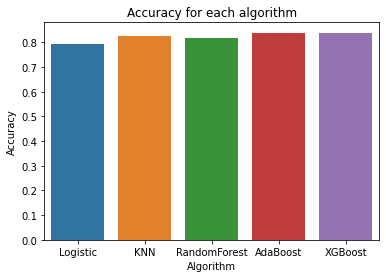

In [17]:
sns.barplot(x=comp['Algorithm'], y=comp['Accuracy'])
plt.title('Accuracy for each algorithm')
plt.show()